<a href="https://colab.research.google.com/github/Regina-Arthur/Coding-Practice-Projects/blob/main/Pytorch_tutorial/RNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####TASK
Build an RNN, GRU, LSTM for a traffic time series data

In [1]:
#The data is stored in my google drive, so I have to load my google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#I will use pandas to load and make changes to the data
import pandas as pd

"""Pandas is an open-source Python library designed for data analysis and manipulation.
The library is built on top of NumPy, which ensures fast and efficient numerical operations.
Numpy can be used but it is not as easy as with pandas."""

# Load CSV data
df = pd.read_csv("/content/drive/MyDrive/traffic_prediction_dataset/traffic.csv")

#df (alone prints the entire data)
#Print out the first 5 data point
print(df.head())

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [3]:
#Convert DateTime to datetime in pandas in order to use pandas special datetime
#classes and function for timeseries projects.
df['datetime'] = pd.to_datetime(df['DateTime'])

# Extract day of week
df['day_of_week'] = df['datetime'].dt.day_name()
df['day_of_week_num'] = df['datetime'].dt.day_of_week

# Extract time (hour and minute)
df['hour'] = df['datetime'].dt.hour

df['minute'] = df['datetime'].dt.minute


# Keeping only the columns I want to use
df = df[['day_of_week', 'day_of_week_num', 'hour', 'minute', 'Junction', 'Vehicles']]

print(df.head())

  day_of_week  day_of_week_num  hour  minute  Junction  Vehicles
0      Sunday                6     0       0         1        15
1      Sunday                6     1       0         1        13
2      Sunday                6     2       0         1        10
3      Sunday                6     3       0         1         7
4      Sunday                6     4       0         1         9


In [4]:
df.describe()


,day_of_week_num,hour,minute,Junction,Vehicles
count,48120.000000,48120.000000,48120.0,48120.000000,48120.000000
mean,2.996010,11.500000,0.0,2.180549,22.791334
std,2.000017,6.922258,0.0,0.966955,20.750063
min,0.000000,0.000000,0.0,1.000000,1.000000
25%,1.000000,5.750000,0.0,1.000000,9.000000
50%,3.000000,11.500000,0.0,2.000000,15.000000
75%,5.000000,17.250000,0.0,3.000000,29.000000
max,6.000000,23.000000,0.0,4.000000,180.000000


In [5]:
import numpy as np

# Select features (inputs), I want to use. They are numerical
features = ['day_of_week_num', 'hour', 'Junction', 'Vehicles']
data = df[features].values.astype(np.float32)

# Sequence length
seq_len = 1
X, y = [], []

#Length of the data is 48120 so - sequence length is 48119
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+1: i+1+seq_len])

X = np.array(X)
y = np.array(y).reshape(len(y),-1)

print(X.shape, y.shape)  # e.g. (N, 24, 4), (N, 1)

(48119, 1, 4) (48119, 4)


In [6]:
"""I removed the minutes column because it was all zeros"""
# Normalize hour
means_hour =df['hour'].mean()
stds_hour =df['hour'].std()
df['hour_norm'] = (df['hour']- means_hour)/stds_hour

means_day_of_week_num =df['day_of_week_num'].mean()
stds_day_of_week_num =df['day_of_week_num'].std()
df['day_of_week_num_norm'] = (df['day_of_week_num']- means_day_of_week_num)/stds_day_of_week_num

means_vehicles =df['Vehicles'].mean()
stds_vehicles =df['Vehicles'].std()
df['vehicles_norm'] = (df['Vehicles']- means_vehicles)/stds_vehicles

means_junction =df['Junction'].mean()
stds_junction =df['Junction'].std()
df['junction_norm'] = (df['Junction']- means_junction)/stds_junction

# Optional: keep only those columns
df = df[['day_of_week_num_norm', 'hour_norm', 'junction_norm', 'vehicles_norm']]

print(df.head())

   day_of_week_num_norm  hour_norm  junction_norm  vehicles_norm
0              1.501982  -1.661308      -1.220893      -0.375485
1              1.501982  -1.516846      -1.220893      -0.471870
2              1.501982  -1.372384      -1.220893      -0.616448
3              1.501982  -1.227923      -1.220893      -0.761026
4              1.501982  -1.083461      -1.220893      -0.664641


In [7]:
# Select features (inputs)
features = ['day_of_week_num_norm', 'hour_norm', 'junction_norm', 'vehicles_norm']
data = df[features].values.astype(np.float32)

# Sequence length
seq_len = 1
X, y = [], []

for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+1: i+1+seq_len])

X = np.array(X)
y = np.array(y).reshape(len(y),-1)

print(X.shape, y.shape)  # e.g. (N, 24, 4), (N, 1)

(48119, 1, 4) (48119, 4)


In [8]:
print(y)

[[ 1.5019825  -1.516846   -1.2208925  -0.4718701 ]
 [ 1.5019825  -1.3723844  -1.2208925  -0.616448  ]
 [ 1.5019825  -1.2279229  -1.2208925  -0.76102585]
 ...
 [ 0.5019908   1.3723844   1.8816291  -0.32729223]
 [ 0.5019908   1.516846    1.8816291  -0.03813647]
 [ 0.5019908   1.6613075   1.8816291  -0.52006274]]


In [9]:
import torch
import torch.nn as nn

X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape, y.shape)

X_train = X[:40000]
X_test = X[40001:]
print(X_train.shape, X_test.shape)

y_train = y[:40000]
y_test = y[40001:]
print(y_train.shape, y_test.shape)

torch.Size([48119, 1, 4]) torch.Size([48119, 4])
torch.Size([40000, 1, 4]) torch.Size([8118, 1, 4])
torch.Size([40000, 4]) torch.Size([8118, 4])


In [10]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [11]:
class TimeSeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # take last time step output
        return out

model = TimeSeriesRNN(input_size=X.shape[2], hidden_size=64, num_layers=10, output_size=4)


In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.1532
Epoch 2, Loss: 0.1579
Epoch 3, Loss: 0.0349
Epoch 4, Loss: 0.0137
Epoch 5, Loss: 0.0098
Epoch 6, Loss: 0.0082
Epoch 7, Loss: 0.2090
Epoch 8, Loss: 0.0098
Epoch 9, Loss: 0.0478
Epoch 10, Loss: 0.0524


In [13]:
model.eval()  # set to evaluation mode
with torch.no_grad():
    predictions = model(X_test).squeeze().cpu().numpy()
    ground_truth = y_test.cpu().numpy()


    # Convert back to real values in order to check if the predictions are correct

    predictions_real = predictions.copy()
    ground_truth_real = ground_truth.copy()

    predictions_real[:, 0] = predictions[:, 0] * stds_day_of_week_num + means_day_of_week_num
    predictions_real[:, 1] = predictions[:, 1] * stds_hour + means_hour
    predictions_real[:, 2] = predictions[:, 2] * stds_junction + means_junction
    predictions_real[:, 3] = predictions[:, 3] * stds_vehicles + means_vehicles

    ground_truth_real[:, 0] = ground_truth[:, 0] * stds_day_of_week_num + means_day_of_week_num
    ground_truth_real[:, 1] = ground_truth[:, 1] * stds_hour + means_hour
    ground_truth_real[:, 2] = ground_truth[:, 2] * stds_junction + means_junction
    ground_truth_real[:, 3] = ground_truth[:, 3] * stds_vehicles + means_vehicles


for i in range(10):
    print(f"Prediction: {predictions_real[i]} | Ground Truth: {ground_truth_real[i]}")

Prediction: [ 1.0078402 18.242764   3.0057945 16.684128 ] | Ground Truth: [ 1. 18.  3. 18.]
Prediction: [ 1.033347  19.246593   3.0024323 18.502836 ] | Ground Truth: [ 1. 19.  3. 13.]
Prediction: [ 1.0204774 20.13945    3.0045266 13.78141  ] | Ground Truth: [ 1. 20.  3. 14.]
Prediction: [ 1.0007615 20.935505   3.004887  14.130114 ] | Ground Truth: [ 1. 21.  3. 19.]
Prediction: [ 0.9724134 21.720207   3.004664  17.81964  ] | Ground Truth: [ 1.       22.        3.       11.999999]
Prediction: [ 0.9105586 23.061777   3.0192661 10.657924 ] | Ground Truth: [ 1. 23.  3. 13.]
Prediction: [ 0.38753   21.973059   3.0439692 12.152914 ] | Ground Truth: [2.000000e+00 9.536743e-07 3.000000e+00 1.100000e+01]
Prediction: [1.5562567 2.9504004 3.0104496 9.011061 ] | Ground Truth: [ 2.  1.  3. 13.]
Prediction: [1.5589348 3.0030289 3.0103507 9.651107 ] | Ground Truth: [ 2.  2.  3. 10.]
Prediction: [1.5196832 3.2542334 3.0094674 8.022617 ] | Ground Truth: [2. 3. 3. 9.]


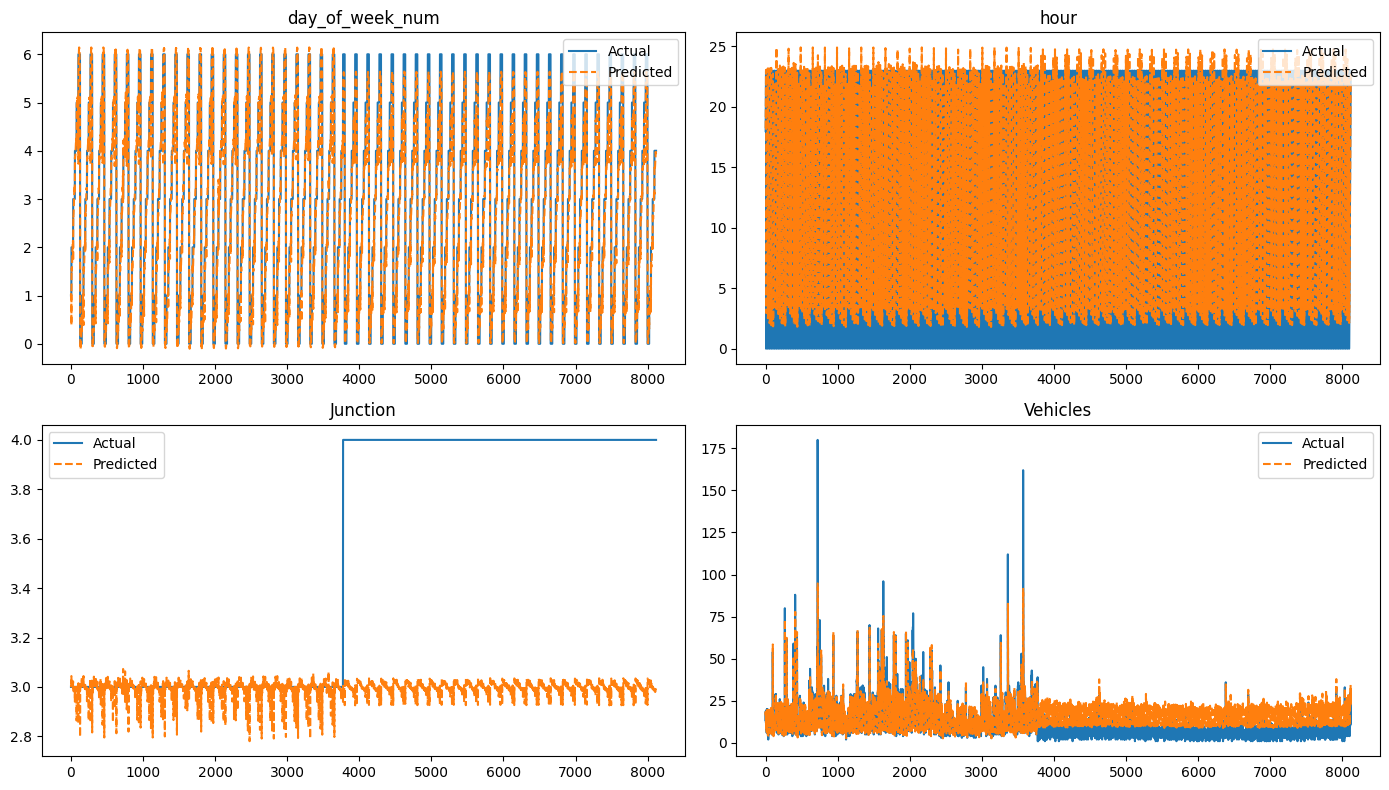

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#Plotting the predictions and groundtruth to see how much their values match
variables = ['day_of_week_num', 'hour', 'Junction', 'Vehicles']

plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(ground_truth_real[:, i], label='Actual')
    plt.plot(predictions_real[:, i], label='Predicted', linestyle='dashed')
    plt.title(variables[i])
    plt.legend()
    plt.tight_layout()
plt.show()

In [15]:
class TimeSeriesGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.GRU(x)
        out = self.fc(out[:, -1, :])  # take last time step output
        return out

model = TimeSeriesGRU(input_size=X.shape[2], hidden_size=64, num_layers=10, output_size=4)


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.2096
Epoch 2, Loss: 0.3358
Epoch 3, Loss: 0.1274
Epoch 4, Loss: 0.0572
Epoch 5, Loss: 0.0282
Epoch 6, Loss: 0.0243
Epoch 7, Loss: 0.0133
Epoch 8, Loss: 0.0121
Epoch 9, Loss: 0.0143
Epoch 10, Loss: 0.0309


In [17]:
model.eval()  # set to evaluation mode
with torch.no_grad():
    predictions = model(X_test).squeeze().cpu().numpy()
    ground_truth = y_test.cpu().numpy()


    # Convert back to real values In order to check if the predictions are correct

    predictions_real = predictions.copy()
    ground_truth_real = ground_truth.copy()

    predictions_real[:, 0] = predictions[:, 0] * stds_day_of_week_num + means_day_of_week_num
    predictions_real[:, 1] = predictions[:, 1] * stds_hour + means_hour
    predictions_real[:, 2] = predictions[:, 2] * stds_junction + means_junction
    predictions_real[:, 3] = predictions[:, 3] * stds_vehicles + means_vehicles

    ground_truth_real[:, 0] = ground_truth[:, 0] * stds_day_of_week_num + means_day_of_week_num
    ground_truth_real[:, 1] = ground_truth[:, 1] * stds_hour + means_hour
    ground_truth_real[:, 2] = ground_truth[:, 2] * stds_junction + means_junction
    ground_truth_real[:, 3] = ground_truth[:, 3] * stds_vehicles + means_vehicles


for i in range(10):
    print(f"Prediction: {predictions_real[i]} | Ground Truth: {ground_truth_real[i]}")





Prediction: [ 0.9059731 18.218422   3.0062497 16.15402  ] | Ground Truth: [ 1. 18.  3. 18.]
Prediction: [ 0.9068092 19.11784    3.005697  18.71332  ] | Ground Truth: [ 1. 19.  3. 13.]
Prediction: [ 0.88872707 20.166435    3.0105195  14.158503  ] | Ground Truth: [ 1. 20.  3. 14.]
Prediction: [ 0.871343  21.133907   3.0107517 14.698534 ] | Ground Truth: [ 1. 21.  3. 19.]
Prediction: [ 0.8480519 22.06932    3.0076334 18.29978  ] | Ground Truth: [ 1.       22.        3.       11.999999]
Prediction: [ 0.8307713 22.43509    3.0049508 12.205956 ] | Ground Truth: [ 1. 23.  3. 13.]
Prediction: [ 2.0122995  -0.21172714  3.0361116  11.562196  ] | Ground Truth: [2.000000e+00 9.536743e-07 3.000000e+00 1.100000e+01]
Prediction: [ 2.0685792  1.2514048  3.0258605 10.140313 ] | Ground Truth: [ 2.  1.  3. 13.]
Prediction: [ 2.0251617  1.7331066  3.0250664 11.697065 ] | Ground Truth: [ 2.  2.  3. 10.]
Prediction: [2.008572  2.6626883 3.0215726 9.870005 ] | Ground Truth: [2. 3. 3. 9.]


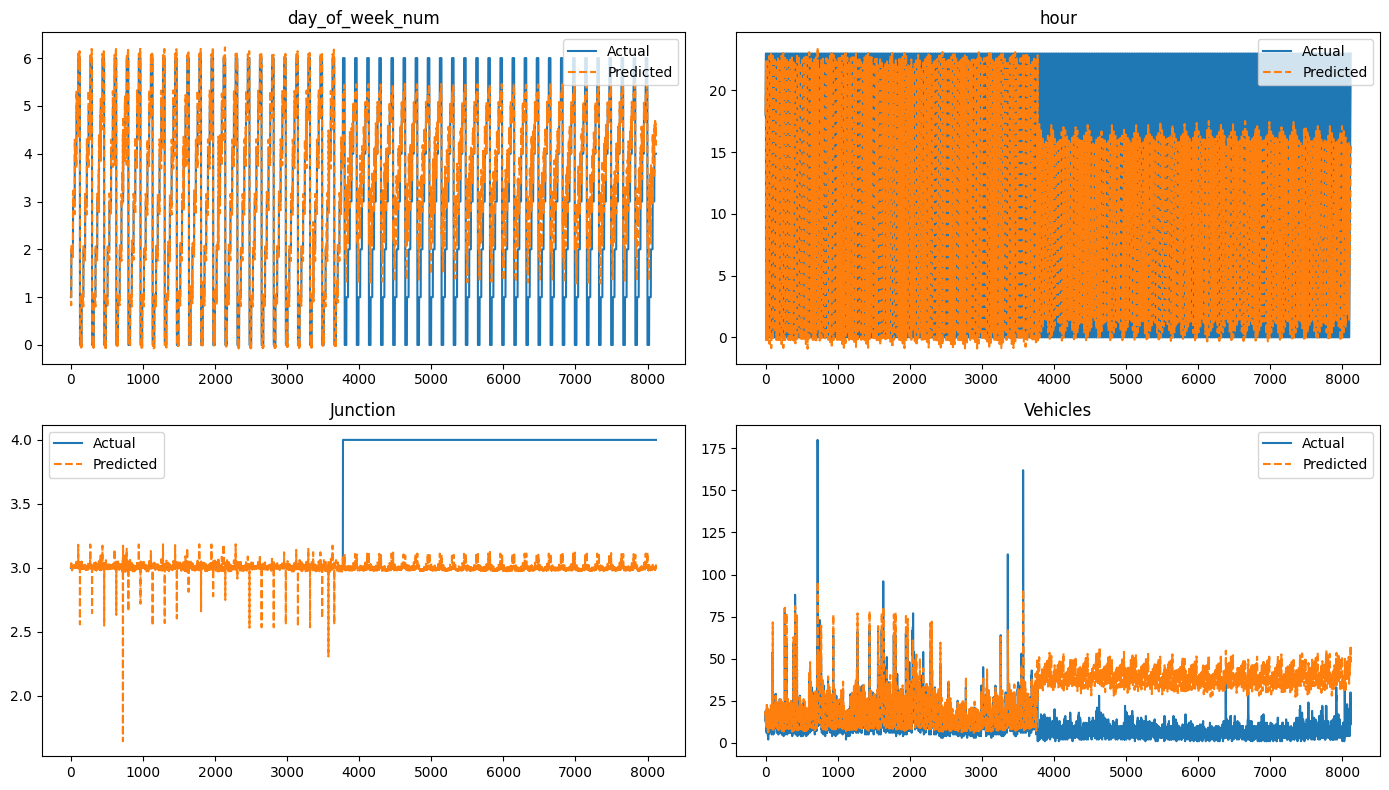

In [18]:
#Plotting the predictions and groundtruth to see how much their values match
variables = ['day_of_week_num', 'hour', 'Junction', 'Vehicles']

plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(ground_truth_real[:, i], label='Actual')
    plt.plot(predictions_real[:, i], label='Predicted', linestyle='dashed')
    plt.title(variables[i])
    plt.legend()
    plt.tight_layout()
plt.show()

In [19]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.LSTM = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.LSTM(x)
        out = self.fc(out[:, -1, :])  # take last time step output
        return out

model = TimeSeriesLSTM(input_size=X.shape[2], hidden_size=64, num_layers=1, output_size=4)


In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0330
Epoch 2, Loss: 0.2958
Epoch 3, Loss: 0.0725
Epoch 4, Loss: 0.0442
Epoch 5, Loss: 0.2161
Epoch 6, Loss: 0.0408
Epoch 7, Loss: 0.0302
Epoch 8, Loss: 0.1145
Epoch 9, Loss: 0.0475
Epoch 10, Loss: 0.0147


In [21]:
model.eval()  # set to evaluation mode
with torch.no_grad():
    predictions = model(X_test).squeeze().cpu().numpy()
    ground_truth = y_test.cpu().numpy()


    # Convert back to real values In order to check if the predictions are correct

    predictions_real = predictions.copy()
    ground_truth_real = ground_truth.copy()

    predictions_real[:, 0] = predictions[:, 0] * stds_day_of_week_num + means_day_of_week_num
    predictions_real[:, 1] = predictions[:, 1] * stds_hour + means_hour
    predictions_real[:, 2] = predictions[:, 2] * stds_junction + means_junction
    predictions_real[:, 3] = predictions[:, 3] * stds_vehicles + means_vehicles

    ground_truth_real[:, 0] = ground_truth[:, 0] * stds_day_of_week_num + means_day_of_week_num
    ground_truth_real[:, 1] = ground_truth[:, 1] * stds_hour + means_hour
    ground_truth_real[:, 2] = ground_truth[:, 2] * stds_junction + means_junction
    ground_truth_real[:, 3] = ground_truth[:, 3] * stds_vehicles + means_vehicles


for i in range(10):
    print(f"Prediction: {predictions_real[i]} | Ground Truth: {ground_truth_real[i]}")

Prediction: [ 1.004946 17.453661  3.019651 14.286099] | Ground Truth: [ 1. 18.  3. 18.]
Prediction: [ 1.0169281 18.486242   3.0309744 16.605597 ] | Ground Truth: [ 1. 19.  3. 13.]
Prediction: [ 1.0557817 20.454395   3.034323  12.10173  ] | Ground Truth: [ 1. 20.  3. 14.]
Prediction: [ 1.1243298 21.948805   3.031463  13.000291 ] | Ground Truth: [ 1. 21.  3. 19.]
Prediction: [ 1.2491163 20.024761   3.0151653 17.14133  ] | Ground Truth: [ 1.       22.        3.       11.999999]
Prediction: [ 1.4302187 14.229457   2.9849792 10.795736 ] | Ground Truth: [ 1. 23.  3. 13.]
Prediction: [ 1.618359   5.9465313  2.953571  10.982716 ] | Ground Truth: [2.000000e+00 9.536743e-07 3.000000e+00 1.100000e+01]
Prediction: [1.9575077 1.140811  3.0180442 8.089894 ] | Ground Truth: [ 2.  1.  3. 13.]
Prediction: [1.955984  2.1072855 3.0133238 9.556416 ] | Ground Truth: [ 2.  2.  3. 10.]
Prediction: [1.957178  3.114277  3.0112484 8.078541 ] | Ground Truth: [2. 3. 3. 9.]


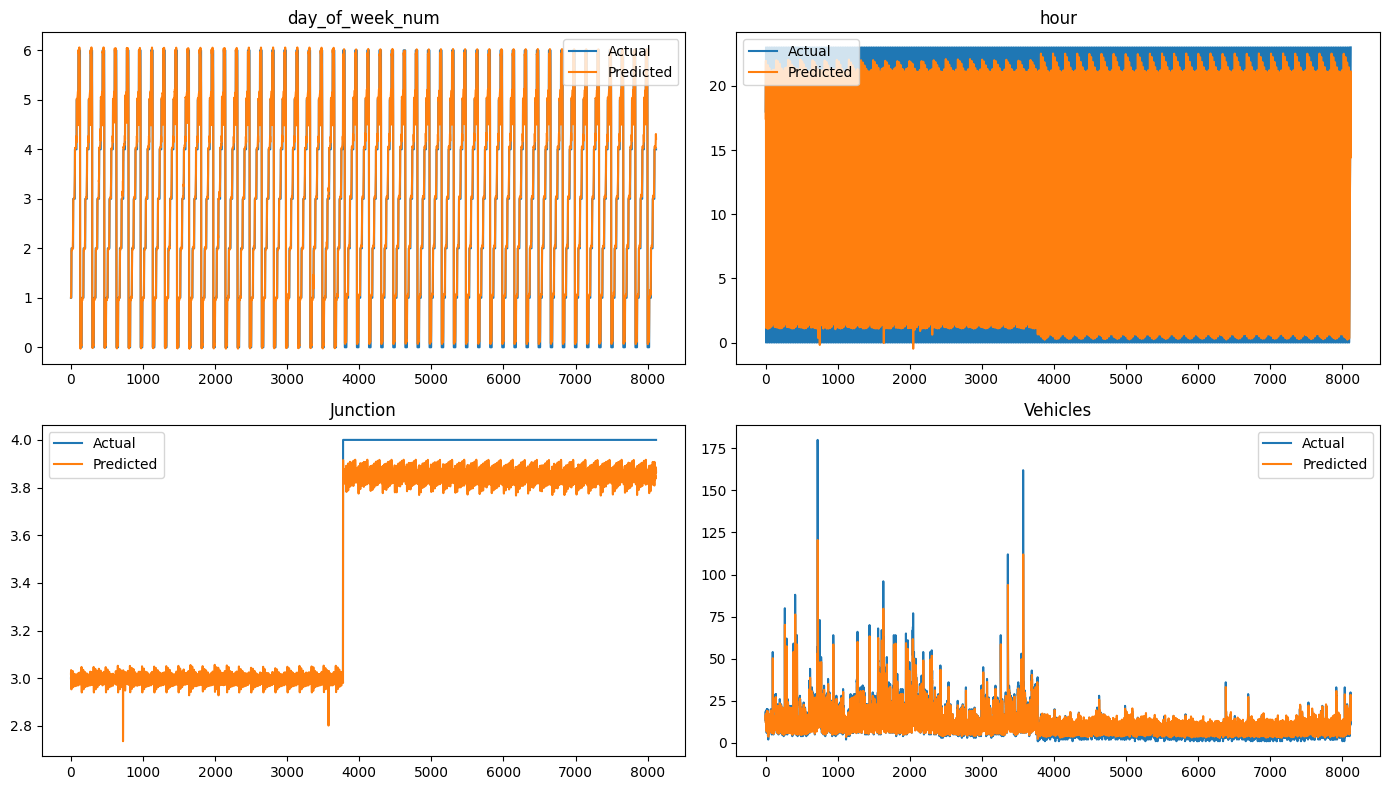

In [22]:
#Plotting the predictions and groundtruth to see how much their values match

variables = ['day_of_week_num', 'hour', 'Junction', 'Vehicles']

plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(ground_truth_real[:, i], label='Actual')
    plt.plot(predictions_real[:, i], label='Predicted', linestyle='solid')
    plt.title(variables[i])
    plt.legend()
    plt.tight_layout()
plt.show()